<a href="https://colab.research.google.com/github/deybvagm/natural-language-processing/blob/master/Sentiment140_with_Glove_and_Dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment140 dataset with Dropout and pretrained word embeddings

This is a dataset with sentiments extracted from twitter. There are 1.600.000 tweets, each annotated as 0=negative or 4=positive to perform a sentiment classification task. You can download the dataset from [kaggle](https://www.kaggle.com/kazanova/sentiment140) but in this notebook we downloaded a cleaned versión from this [location](https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv)

We are going to use Dropout regularization to combat overfitting as well as a pretrained GloVe word embeddings 

In [0]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

## Hyperparameters

In [0]:

embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=500000 #160000
test_portion=.1



In [0]:
# vocab_size = 50000

## Downloading dataset

In [0]:
# Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv
# I then hosted it on my site to make it easier to use in this notebook

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv


--2019-09-04 10:39:20--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.140.128, 2a00:1450:400c:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.140.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M  92.9MB/s    in 2.5s    

2019-09-04 10:39:22 (92.9 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



In [0]:
corpus = []
num_sentences = 0

with open("/tmp/training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        list_item=[]
        list_item.append(row[5])
        this_label=row[0]
        if this_label=='0':
            list_item.append(0)
        else:
            list_item.append(1)
        num_sentences = num_sentences + 1
        corpus.append(list_item)




In [0]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


## Text preprocessing

In [0]:
training_sentences = []
training_labels = []

validation_sentences = []
validation_labels = []

split = int(test_portion * training_size)

random.shuffle(corpus)
for x in range(training_size + split):
  if x < training_size:    
    training_sentences.append(corpus[x][0])
    training_labels.append(corpus[x][1])
  else:
    validation_sentences.append(corpus[x][0])
    validation_labels.append(corpus[x][1])
  

tokenizer = Tokenizer()
# tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)



In [0]:
print(test_portion)
print(training_size)
print(len(training_sentences))
print(len(validation_sentences))
print(split)

0.1
500000
500000
50000
50000


In [0]:
print(vocab_size)
print(word_index['i'])
# Expected Output
# 138858
# 1

311863
1


## GloVe Embeddings

In [0]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
  


--2019-09-04 10:40:43--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.140.128, 2a00:1450:400c:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.140.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M  68.0MB/s    in 4.9s    

2019-09-04 10:40:48 (66.9 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [0]:
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;


In [0]:
# reverse_word_index = dict([(num, word) for word, num in word_index.items()])

# def get_word(token):
#   return reverse_word_index[token]

In [0]:

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [0]:
# embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
# for i in range(1, vocab_size):
#   word = get_word(i)
#   embedding_vector = embeddings_index.get(word)
#   if embedding_vector is not None:
#     embeddings_matrix[i] = embedding_vector
    

In [0]:
print(len(embeddings_matrix))
# Expected Output
# 138859

311864


## Training

In [0]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

def plot_graph(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric])
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()
  
  

In [0]:
num_epochs = 20

### Model with regularization

In [0]:
model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
#     tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=True),
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(validation_padded, validation_labels))

print("Training Complete")


W0904 10:41:50.721251 139674395035520 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0904 10:41:50.726685 139674395035520 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0904 10:41:51.122393 139674395035520 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.o

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           31186400  
_________________________________________________________________
dropout (Dropout)            (None, 16, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 64)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 31,251,553
Trainable params: 31,251,553
Non-trainable params: 0
____________________________________________

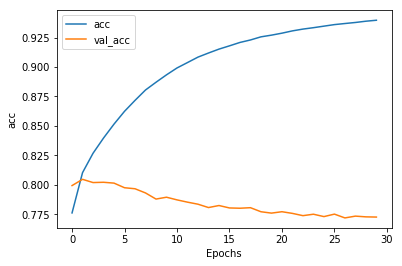

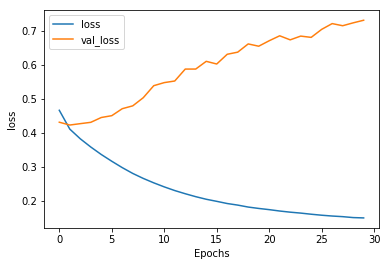

In [0]:
plot_graph(history, 'acc')
plot_graph(history, 'loss')

In [0]:
# #-----------------------------------------------------------
# # Retrieve a list of list results on training and test data
# # sets for each training epoch
# #-----------------------------------------------------------
# acc=history.history['acc']
# val_acc=history.history['val_acc']
# loss=history.history['loss']
# val_loss=history.history['val_loss']

# epochs=range(len(acc)) # Get number of epochs

# #------------------------------------------------
# # Plot training and validation accuracy per epoch
# #------------------------------------------------
# plt.plot(epochs, acc, 'r')
# plt.plot(epochs, val_acc, 'b')
# plt.title('Training and validation accuracy')
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.legend(["Accuracy", "Validation Accuracy"])

# plt.figure()

# #------------------------------------------------
# # Plot training and validation loss per epoch
# #------------------------------------------------
# plt.plot(epochs, loss, 'r')
# plt.plot(epochs, val_loss, 'b')
# plt.title('Training and validation loss')
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend(["Loss", "Validation Loss"])

# plt.figure()


# # Expected Output
# # A chart where the validation loss does not increase sharply!

### Simple neural network

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size + 1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

print(model.summary())

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(validation_padded, validation_labels))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 16, 100)           31171300  
_________________________________________________________________
global_average_pooling1d_1 ( (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 606       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 31,171,913
Trainable params: 613
Non-trainable params: 31,171,300
_________________________________________________________________
None
Train on 500000 samples, validate on 50000 samples
Epoch 1/30
500000/500000 [==============================] - 57s 113us/sample - loss: 0.5985 - acc: 0.6829 - val_loss: 0.5857 - val_acc: 0.6927
Epoch 2/30
500000/500000 [=============

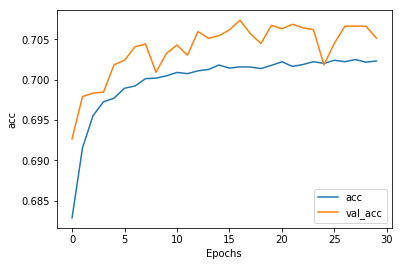

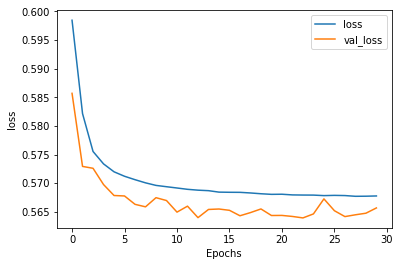

In [0]:
plot_graph(history, 'acc')
plot_graph(history, 'loss')

### CNN


In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size + 1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

print(model.summary())

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(validation_padded, validation_labels))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 16, 100)           3682200   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12, 128)           64128     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 774       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 7         
Total params: 3,747,109
Trainable params: 64,909
Non-trainable params: 3,682,200
_________________________________________________________________
None
Train on 25000 samples, validate on 2500 samples
Epoch 1/30
25000/25000 [===========================

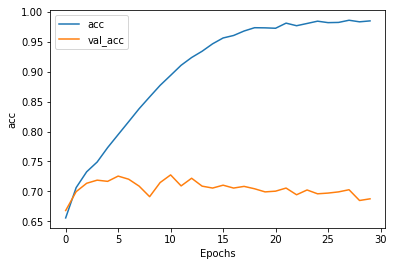

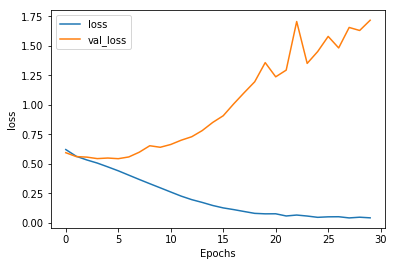

In [0]:
plot_graph(history, 'acc')
plot_graph(history, 'loss')

## Results

Things to try:
- **160.000 training size**: model with dropout is better -> 0.75 accuracy and loss 0.52 with some overfitting. The scond accuracy is 0.72 (CNN)
- **less training size (25.000)**: Less accuracy with regularization -> 0.7 and a with much more overfitting
- **With larger training_size (500.000)**: model with dropout improves to -> 0.77 accuracy and loss 0.47. Very little overfitting with this configuration
- without regularization
- without GloVe embeddings
- With vocab_size parameter
- With trainable embeddings
- Change dropout value

| Configuration | Accuracy | Loss | Overfitting? |
|---------------|----------|------|--------------|
| 160K for training | 0.75     | 0.52 | yes      |
| 25K for training  | 0.7      | NA   | yes      |
| 500K for training | 0.77     | 0.47 | no       |
| Without regularization | 0.75 | 0.50 | yes     |
| Without GloVe Embeddings | 0.77 | 0.57 | yes   |
| With fixed vocab_size (50K) | 0.77 | 0.47 | no |
| With trainable embeddings | 0.77 | 0.73 | yes  |
| With Dropout = 0.5 | 0.75 | 0.52        | no   |


## Conclusions

- You need a large corpus in order to avoid overfitting
- You should use regularization techniques since with text the overfitting by default is high